<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/6/lab.ipynb">link</a>

Authorize google + kaggle

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Be sure, that we authorized and have an access to kaggle

In [2]:
%ls /content/.kaggle/

kaggle.json*


# **Part 1: Download dataset, extract, split, check data distribution**

In [3]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download datamunge/sign-language-mnist -p /content/kaggle/signlanguage

 53% 33.0M/62.6M [00:01<00:01, 26.5MB/s]
100% 62.6M/62.6M [00:01<00:00, 44.6MB/s]


Extract .zip

In [4]:
!unzip kaggle/signlanguage/sign-language-mnist.zip -d data

Archive:  kaggle/signlanguage/sign-language-mnist.zip
  inflating: data/amer_sign2.png     
  inflating: data/amer_sign3.png     
  inflating: data/american_sign_language.PNG  
  inflating: data/sign_mnist_test.csv  
  inflating: data/sign_mnist_test/sign_mnist_test.csv  
  inflating: data/sign_mnist_train.csv  
  inflating: data/sign_mnist_train/sign_mnist_train.csv  


In [5]:
%ls

adc.json  data/  kaggle/  sample_data/


In [0]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

TRAIN_PATH = './data/sign_mnist_train.csv'
TEST_PATH = './data/sign_mnist_test.csv'

IMAGE_WIDTH=28
IMAGE_HEIGHT=28
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# train, val = train_test_split(train, test_size=0.2, random_state=42)


def split_dataset_to_x_y(df, is_numpy=True):
    y = pd.concat([df['label'], pd.get_dummies(df['label'], prefix='label')], axis=1)
    df.drop(['label'], axis=1, inplace=True)
    y.drop(['label'], axis=1, inplace=True)
    X = (df / 255).values.reshape((df.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))  # data scaling & reshaping

    return X, y.to_numpy() if is_numpy else y


X, Y = split_dataset_to_x_y(train)
X_test, Y_test = split_dataset_to_x_y(test, is_numpy=False)

LABELS = 24

Check data distribution

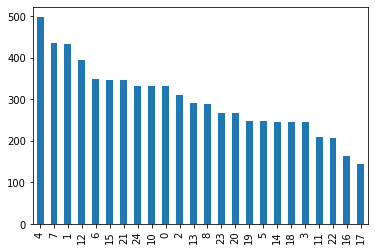

In [0]:
y_test.value_counts().plot.bar()

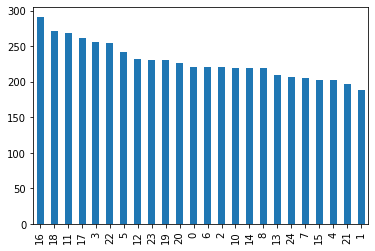

In [0]:
y_val.value_counts().plot.bar()

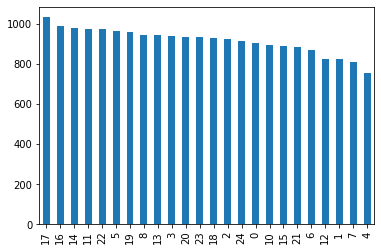

In [0]:
y_train.value_counts().plot.bar()

# **Part 2: DNN model**

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(LABELS, activation='softmax')) # 2 classes: dog and cat

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

model.save_weights('initial.h5')

Using TensorFlow backend.














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 64)        25

Train without data augmentation:

In [42]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold

n_folds = 10
skf = KFold(n_folds, shuffle=True).split(X)

datagen = ImageDataGenerator()
datagen.fit(X)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)

model.load_weights('initial.h5')

for train_index, test_index in skf:
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=Y[train_index],Y[test_index]
    model.fit_generator(
      datagen.flow(x_train, y_train, batch_size=32),
      steps_per_epoch=len(x_train) / 32,
      validation_data=datagen.flow(x_test, y_test),
      validation_steps=len(x_test) / 32,
      epochs=3
    )

Epoch 1/3
773/772 [==============================] - 7s 9ms/step - loss: 1.2126 - acc: 0.6373 - val_loss: 0.1387 - val_acc: 0.9599
Epoch 2/3
773/772 [==============================] - 7s 9ms/step - loss: 0.2359 - acc: 0.9206 - val_loss: 0.0832 - val_acc: 0.9720
Epoch 3/3
773/772 [==============================] - 7s 9ms/step - loss: 0.1167 - acc: 0.9611 - val_loss: 0.1063 - val_acc: 0.9654
Epoch 1/3
773/772 [==============================] - 7s 9ms/step - loss: 0.0874 - acc: 0.9722 - val_loss: 0.0085 - val_acc: 0.9964
Epoch 2/3
773/772 [==============================] - 7s 9ms/step - loss: 0.0606 - acc: 0.9795 - val_loss: 0.0477 - val_acc: 0.9825
Epoch 3/3
773/772 [==============================] - 7s 9ms/step - loss: 0.0590 - acc: 0.9814 - val_loss: 0.0521 - val_acc: 0.9843
Epoch 1/3
773/772 [==============================] - 7s 9ms/step - loss: 0.0460 - acc: 0.9857 - val_loss: 0.0062 - val_acc: 0.9971
Epoch 2/3
773/772 [==============================] - 7s 9ms/step - loss: 0.0429 - a

Model evaluate:

In [45]:
score, acc = model.evaluate(X_test, Y_test, verbose=1)
print(score, acc)

7172/7172 [==============================] - 1s 76us/step
0.2936273631751099 0.9562186279977691


# **Part 3: Applying data augmentation**

In [28]:
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X)

skf = KFold(n_folds, shuffle=True).split(X)

model.load_weights('initial.h5')
# fits the model on batches with real-time data augmentation:
for train_index, test_index in skf:
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=Y[train_index],Y[test_index]
    model.fit_generator(
      datagen.flow(x_train, y_train, batch_size=32),
      steps_per_epoch=len(x_train) / 32,
      validation_data=datagen.flow(x_test, y_test),
      validation_steps=len(x_test) / 32,
      epochs=3
    )

Epoch 1/3
773/772 [==============================] - 10s 14ms/step - loss: 1.6367 - acc: 0.5087 - val_loss: 0.5759 - val_acc: 0.8044
Epoch 2/3
773/772 [==============================] - 11s 14ms/step - loss: 0.6613 - acc: 0.7774 - val_loss: 0.3136 - val_acc: 0.8933
Epoch 3/3
773/772 [==============================] - 10s 14ms/step - loss: 0.4256 - acc: 0.8552 - val_loss: 0.1953 - val_acc: 0.9348
Epoch 1/3
773/772 [==============================] - 11s 14ms/step - loss: 0.3292 - acc: 0.8900 - val_loss: 0.0796 - val_acc: 0.9727
Epoch 2/3
773/772 [==============================] - 11s 14ms/step - loss: 0.2912 - acc: 0.9042 - val_loss: 0.0758 - val_acc: 0.9778
Epoch 3/3
773/772 [==============================] - 11s 14ms/step - loss: 0.2499 - acc: 0.9172 - val_loss: 0.0642 - val_acc: 0.9782
Epoch 1/3
773/772 [==============================] - 11s 14ms/step - loss: 0.2213 - acc: 0.9286 - val_loss: 0.2211 - val_acc: 0.9334
Epoch 2/3
773/772 [==============================] - 11s 14ms/step - 

Model evaluation

In [34]:
score, acc = model.evaluate(X_test, Y_test, verbose=1)
print(score, acc)

7172/7172 [==============================] - 1s 80us/step
0.12932936984590399 0.9556609035136643


# **Part 4: Using transfer learning**

Data transforamtion for applying VGG transfer learning

In [0]:
import numpy as np
import cv2

def x_to_vgg_input(X):
    x = np.reshape(X, (X.shape[0], 28, 28))
    x = np.asarray([cv2.resize(i, (32,32)) for i in x], dtype=np.float32)
    x = np.repeat(x[..., np.newaxis], 3, -1)
    return x

Defining NN model

In [36]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# load model
vgg = VGG16(include_top=False, input_shape=(32, 32, 3))
# mark loaded layers as not trainable
for layer in vgg.layers:
	layer.trainable = False

# define a new output layer to connect with the last fc layer in vgg
x = Flatten()(vgg.layers[-1].output)
class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
bn = BatchNormalization()(class1)
do = Dropout(0.5)(bn)
output_layer = Dense(LABELS, activation='softmax', name='predictions')(do)

# combine the original VGG model with the new output layer
vgg = Model(inputs=vgg.input, outputs=output_layer)

vgg.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X)

Train the model

In [38]:
# fits the model on batches with real-time data augmentation:
skf = KFold(n_folds, shuffle=True).split(X)

# fits the model on batches with real-time data augmentation:
for train_index, test_index in skf:
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=Y[train_index],Y[test_index]
    vgg.fit_generator(
      datagen.flow(x_to_vgg_input(x_train), y_train, batch_size=32),
      steps_per_epoch=len(x_train) / 32,
      validation_data=datagen.flow(x_to_vgg_input(x_test), y_test),
      validation_steps=len(x_test) / 32,
      epochs=3
    )

Epoch 1/3
773/772 [==============================] - 18s 23ms/step - loss: 0.9605 - acc: 0.6881 - val_loss: 0.5249 - val_acc: 0.8285
Epoch 2/3
773/772 [==============================] - 17s 22ms/step - loss: 0.5059 - acc: 0.8283 - val_loss: 0.4967 - val_acc: 0.8161
Epoch 3/3
773/772 [==============================] - 17s 22ms/step - loss: 0.4127 - acc: 0.8594 - val_loss: 0.3566 - val_acc: 0.8762
Epoch 1/3
773/772 [==============================] - 17s 21ms/step - loss: 0.3751 - acc: 0.8715 - val_loss: 0.3257 - val_acc: 0.8980
Epoch 2/3
773/772 [==============================] - 17s 21ms/step - loss: 0.3522 - acc: 0.8763 - val_loss: 0.3365 - val_acc: 0.8751
Epoch 3/3
773/772 [==============================] - 16s 21ms/step - loss: 0.3455 - acc: 0.8834 - val_loss: 0.2590 - val_acc: 0.9119
Epoch 1/3
773/772 [==============================] - 17s 21ms/step - loss: 0.3267 - acc: 0.8883 - val_loss: 0.3198 - val_acc: 0.8827
Epoch 2/3
773/772 [==============================] - 17s 21ms/step - 

Evaluate the model

In [41]:
score, acc = vgg.evaluate(x_to_vgg_input(X_test), Y_test, verbose=1)
print(score, acc)

7172/7172 [==============================] - 3s 366us/step
0.22242178853520186 0.9277746793084216
